# ChickWeight
The body weights of the chicks were measured at birth and every second day thereafter until day 20. They were also measured on day 21. There were four groups on chicks on different protein diets.

In the background, running `almond` as the jupyter integration with `ammonite`.

## Preliminaries
Import `scala-infer`, plotting (`evilplot`), csv reader

In [16]:
interp.repositories() ++= Seq(
    coursier.MavenRepository("https://dl.bintray.com/cibotech/public"),
    coursier.MavenRepository("https://dl.bintray.com/fvlankvelt/maven")
)

In [ ]:
import $ivy.`fvlankvelt::scala-infer:0.2-SNAPSHOT`
import $ivy.`com.cibo::evilplot-repl:0.6.3`
import $ivy.`com.cibo::evilplot-jupyter-scala:0.6.3`
import $ivy.`org.jupyter-scala::kernel-api:0.4.1`
import $ivy.`com.github.tototoshi::scala-csv:1.3.5`

In [ ]:
import scappla._
import scappla.Real._
import scappla.Functions._
import scappla.distributions._
import scappla.guides._
import scappla.optimization._
import scappla.tensor.TensorExpr._
import scappla.tensor._

import com.github.tototoshi.csv.CSVReader

import com.cibo.evilplot._
import com.cibo.evilplot.colors._
import com.cibo.evilplot.geometry._
import com.cibo.evilplot.numeric._
import com.cibo.evilplot.plot._
import com.cibo.evilplot.plot.aesthetics.Theme
import com.cibo.evilplot.plot.aesthetics.DefaultTheme._
import com.cibo.evilplot.plot.renderers._

Compatibility issue: evilplot integration with almond

In [ ]:
implicit class JupyterScalaDrawableMethods(drawable: Drawable) {
    def show: Unit = {
        val bi = drawable.asBufferedImage
        val baos = new java.io.ByteArrayOutputStream()
        javax.imageio.ImageIO.write(bi, "png", baos)
        val bytes = baos.toByteArray()
        kernel.publish.display(almond.interpreter.api.DisplayData.png(bytes))
    }
}

implicit class JupyterScalaPlotMethods(plot: Plot) {
    def show(implicit theme: Theme): Unit =
        plot.render()(theme).show
}

# Read in the data

In [ ]:
case class Record(weight: Float, time: Float, diet: Int)

// Tensor shape - let's make it typed!
case class Diet(size: Int) extends Dim[Diet]

val (n_diets, diets)= {{
    val data = {
        val reader = CSVReader.open("chickweight.csv")
        val raw = reader.allWithHeaders()
        raw.map { row =>
            Record(row("weight").toFloat, row("Time").toFloat, row("Diet").toInt)
        }.toArray
    }

    val n_diets = data.map {
        _.diet
    }.max
    val diets = for {diet <- 1 to n_diets} yield {
        val diet_data = data.filter(_.diet == diet)
        val dim = Diet(diet_data.length)
        val times = diet_data.map { _.time }
        val weights = diet_data.map { _. weight }
        (
            dim,
            Tensor(dim, ArrayTensor(dim.sizes, times)),
            Tensor(dim, ArrayTensor(dim.sizes, weights))
        )
    }
    (n_diets, diets)
}}


Set up renderer - use the same color for a diet in all following plots

In [ ]:
val colors = Color.getDefaultPaletteSeq(n_diets).map { _.hsla.copy(opacity = 0.5)}
val renderer = new PointRenderer[Point3d[Int]] {
    
    def render(point: Point3d[Int]): Drawable = {
        Disc.centered(4).filled(colors(point.z))
    }

}

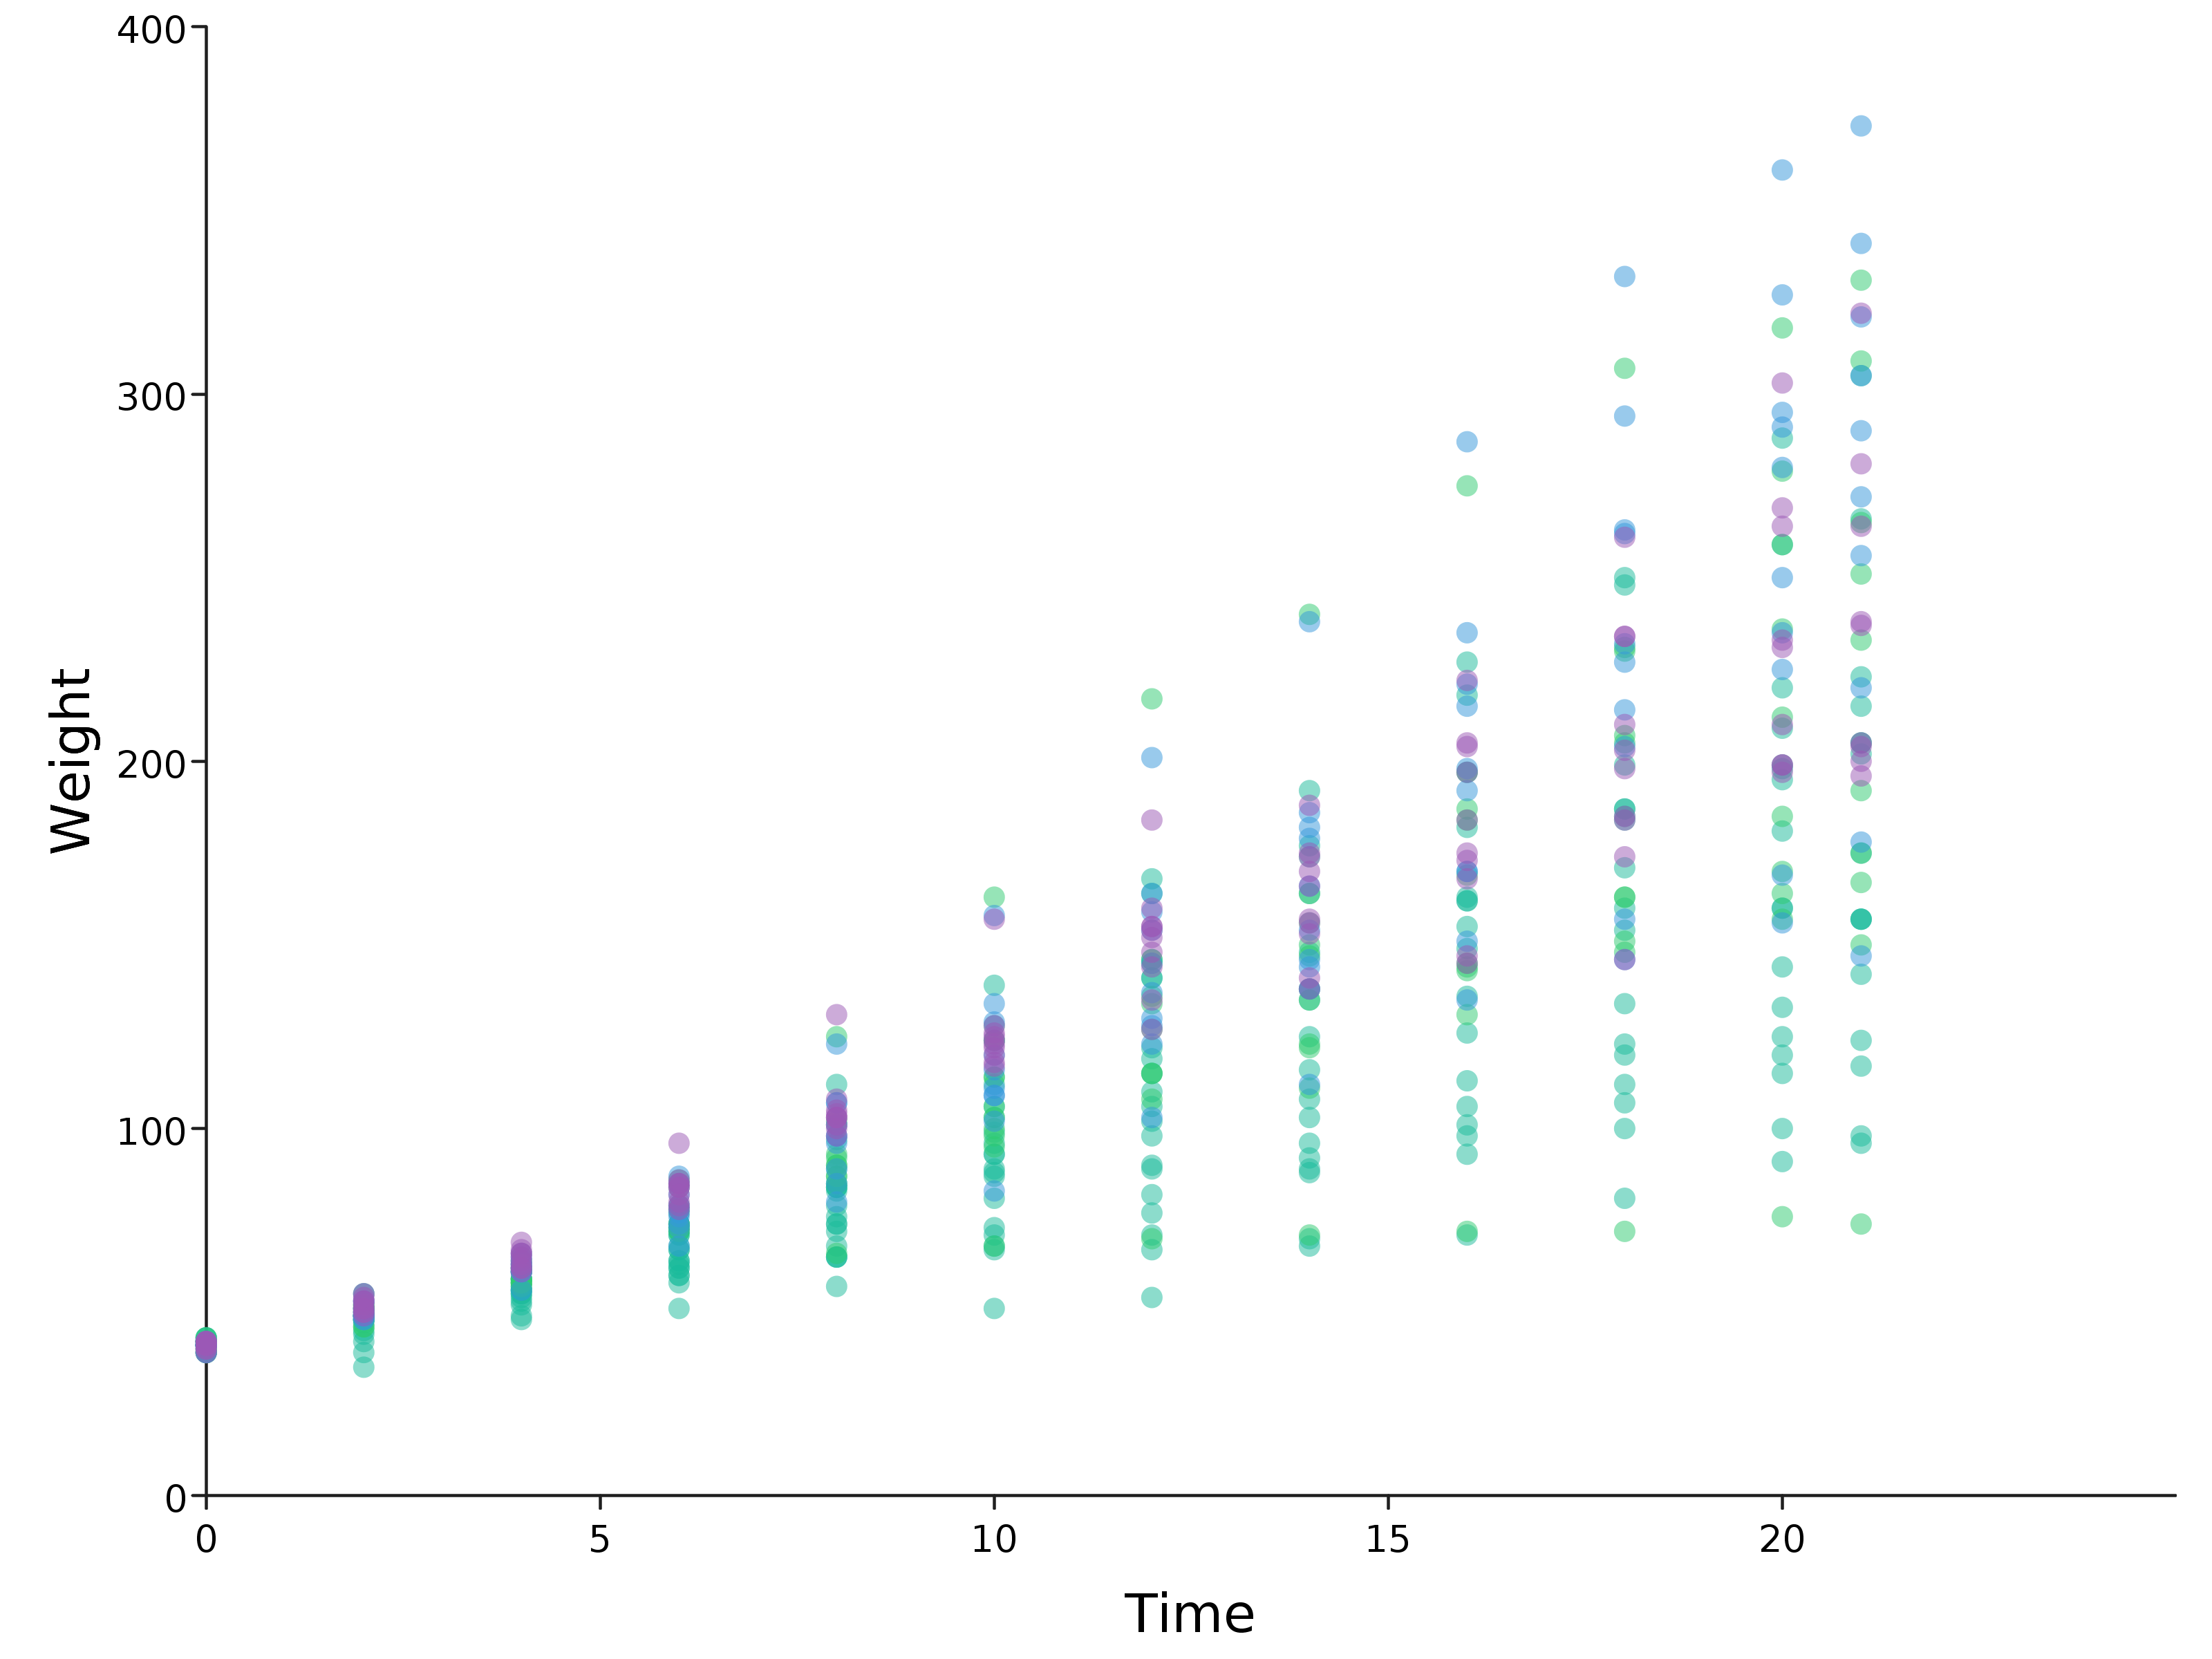

In [22]:
{{
    val points = diets.zipWithIndex.flatMap { case ((_, ttimes, tweights), di) =>
        ttimes.data.data.zip(tweights.data.data).map { case (t, w) =>
            Point3d[Int](t, w, di)
        }
    }
    ScatterPlot(
        points,
        pointRenderer = Some(renderer)
    ).xAxis().yAxis().xLabel("Time").yLabel("Weight").frame().show
}}

In [ ]:
val sgd = new Adam(alpha = 0.1, epsilon = 1e-4)

// weight at birth
val intercept_guide = ReparamGuide(Normal(sgd.param(40.0), exp(sgd.param(0.0))))

// variance in growth rate at birth
val intercept_var_guide = ReparamGuide(Normal(sgd.param(0.0), exp(sgd.param(0.0))))

// each diet gets an average growth rate and a variance in growth rate
val data_with_guides = diets.map { diet =>
    (
        diet,
        (
            ReparamGuide(Normal(sgd.param(10.0), exp(sgd.param(1.0)))),
            ReparamGuide(Normal(sgd.param(0.0), exp(sgd.param(0.0))))
        )
    )
}

val model = infer {
    val intercept = sample(Normal(40.0, 1.0), intercept_guide)
    val intercept_var = exp(sample(Normal(0.0, 0.2), intercept_var_guide))

    val slopes = for {
        ((dim, times, weights), (slope_mu_guide, slope_var_guide)) <- data_with_guides
    } yield {
        val tc = times.const

        val intercept_tensor = broadcast(intercept, dim)
        val slope_mu = sample(Normal(10.0, 3.0), slope_mu_guide)
        val slope_mu_tensor = broadcast(slope_mu, dim)

        val intercept_var_tensor = broadcast(intercept_var, dim)
        val slope_var = exp(sample(Normal(0.0, 1.0), slope_var_guide))
        val slope_var_tensor = broadcast(slope_var, dim)

        observe(Normal(
            intercept_tensor + slope_mu_tensor * tc,
            intercept_var_tensor + slope_var_tensor * tc
        ), weights.const)

        (slope_mu, slope_var)
    }

    (intercept, intercept_var, slopes)
}

val samples = for { _ <- 0 until 2000 } yield {
    model.sample()
}

val mus = samples.map { case (intercept, _, slopes) =>
    (intercept.v, slopes.map { _._1.v })
}
val sigmas = samples.map { case (_, intercept_var, slopes) =>
    (intercept_var.v, slopes.map { _._2.v })
}

## Samples of the average weight growth

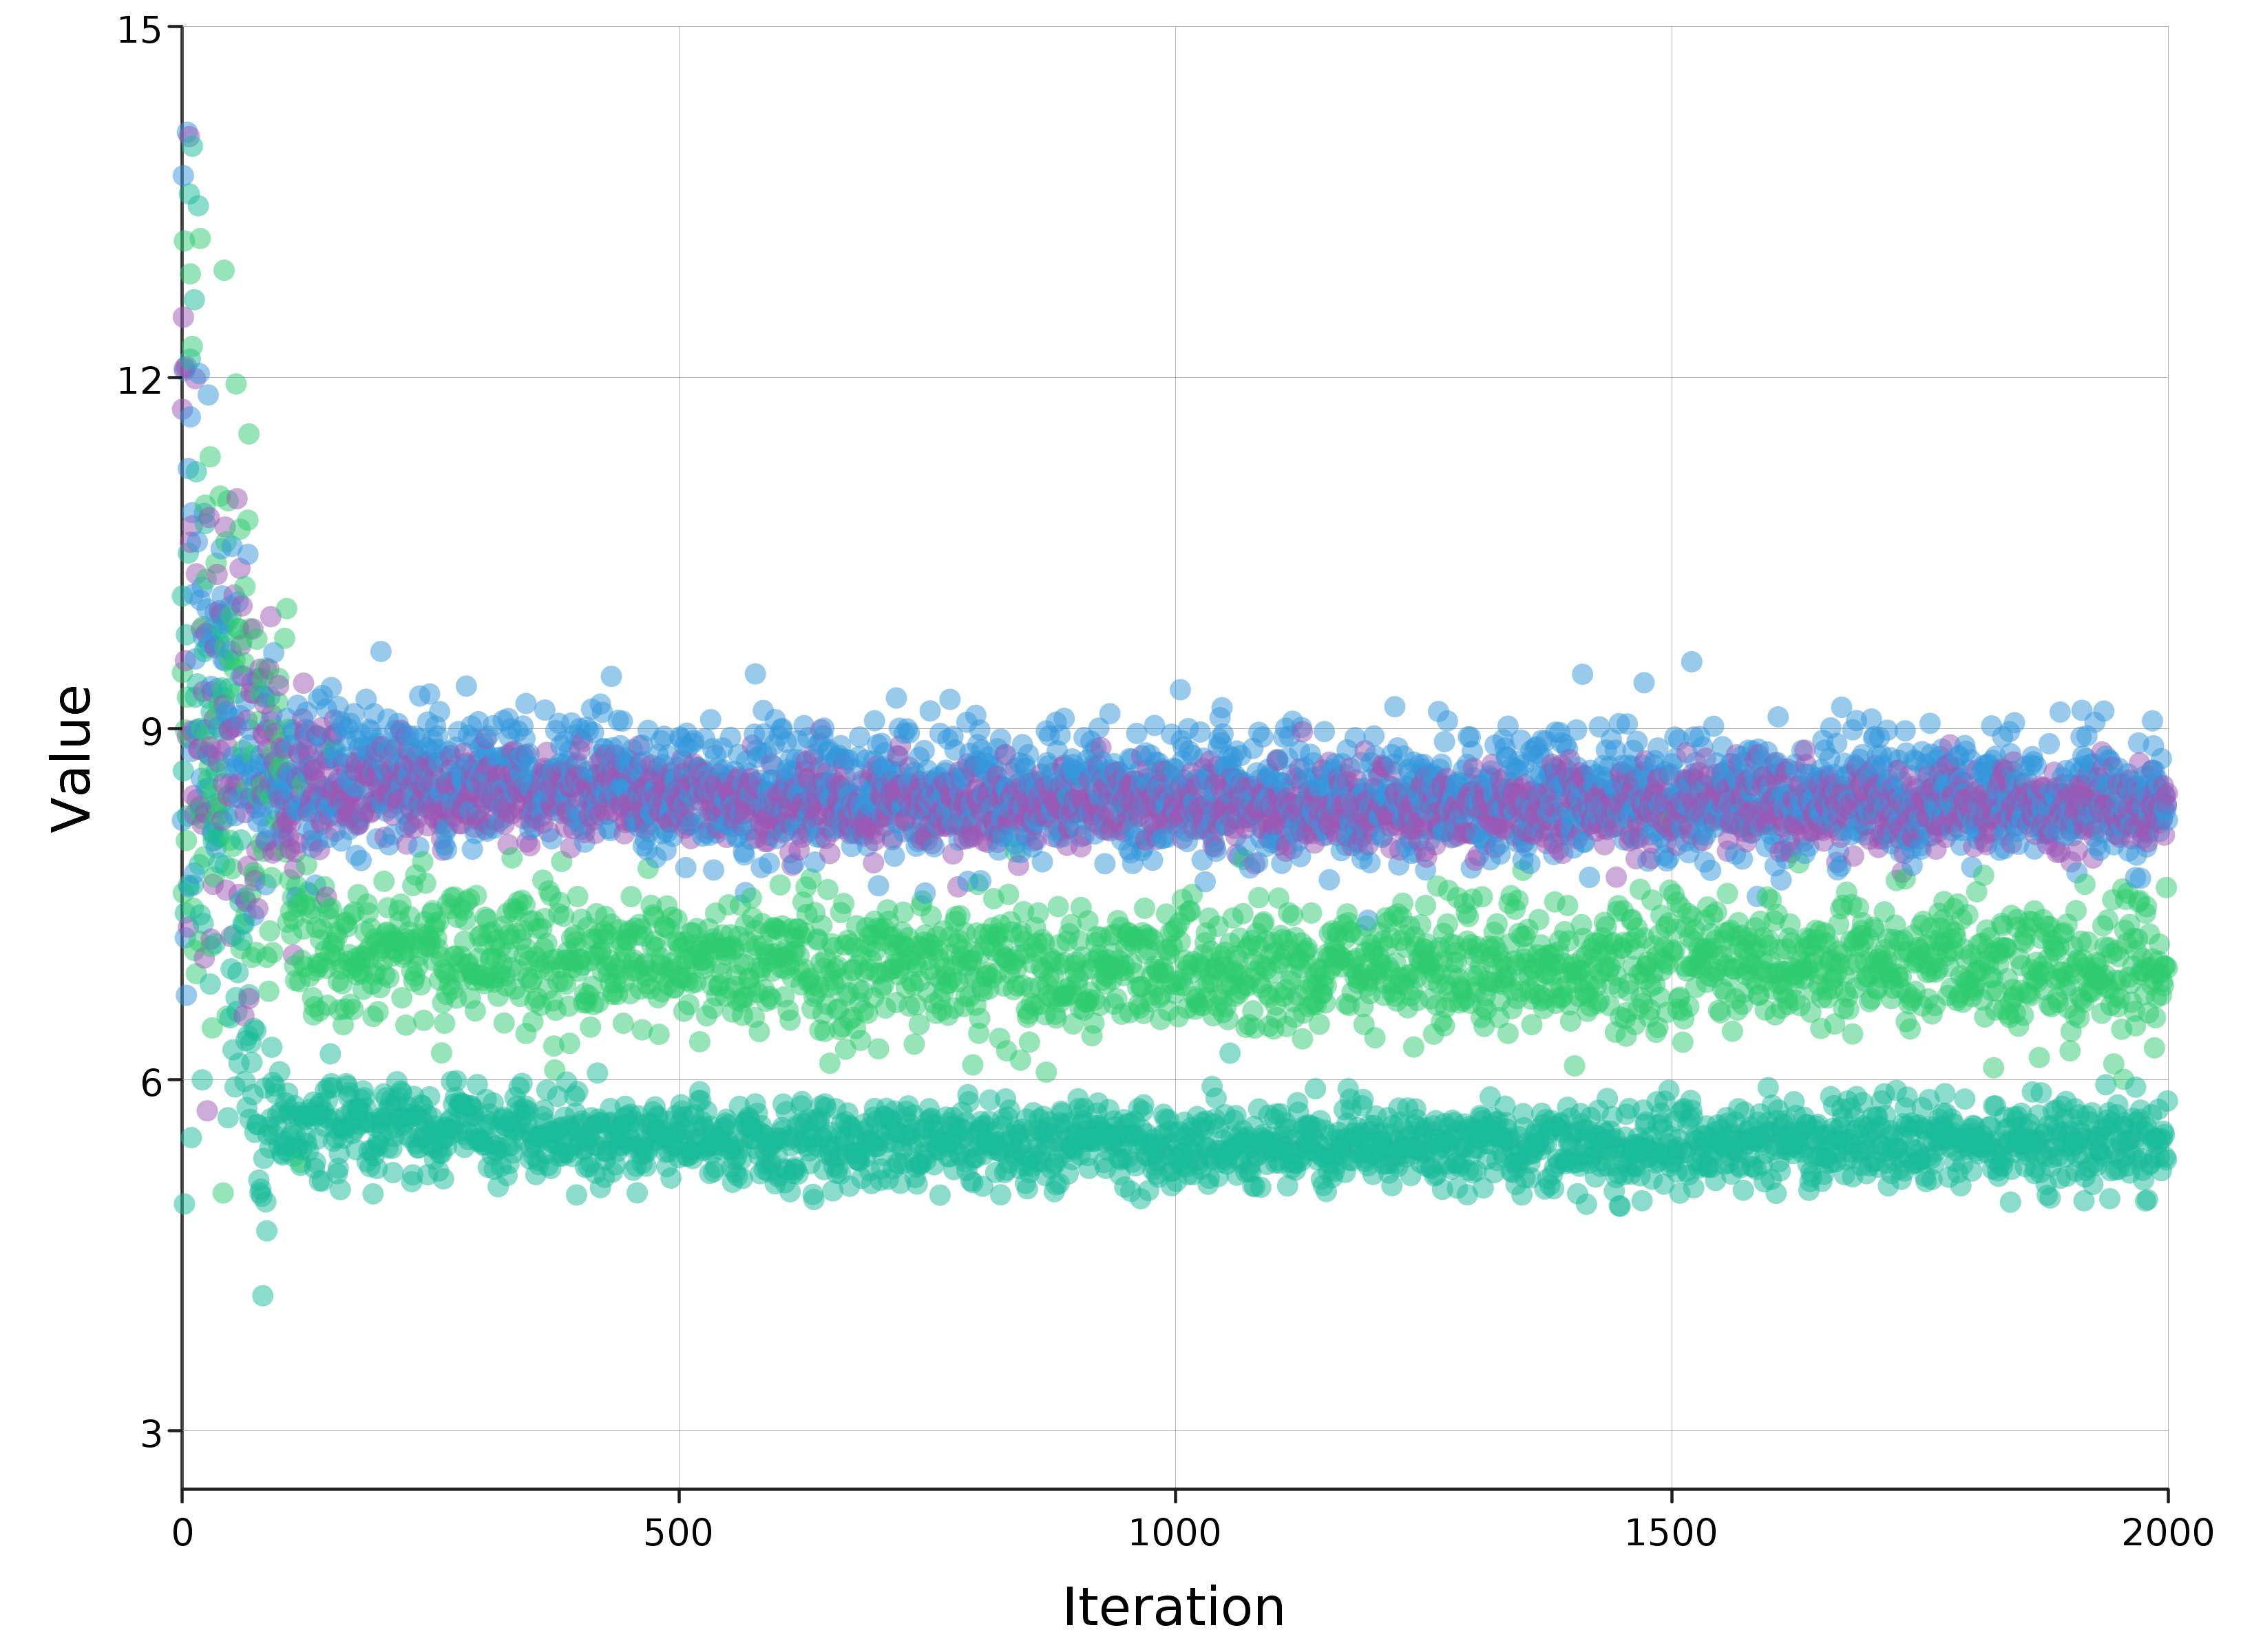

In [24]:
{{
    val points = mus.zipWithIndex.flatMap { case (s, i) =>
        s._2.zipWithIndex.map { case (d, di) =>
            Point3d[Int](i, d, di)
        }
    }
    ScatterPlot(
        points,
        pointRenderer = Some(renderer)
    ).frame()
    .xAxis().xLabel("Iteration")
    .yAxis().yLabel("Value")
    .xGrid().yGrid()
    .ybounds(Bounds(2.5, 15))
    .rightLegend()
    .show
}}

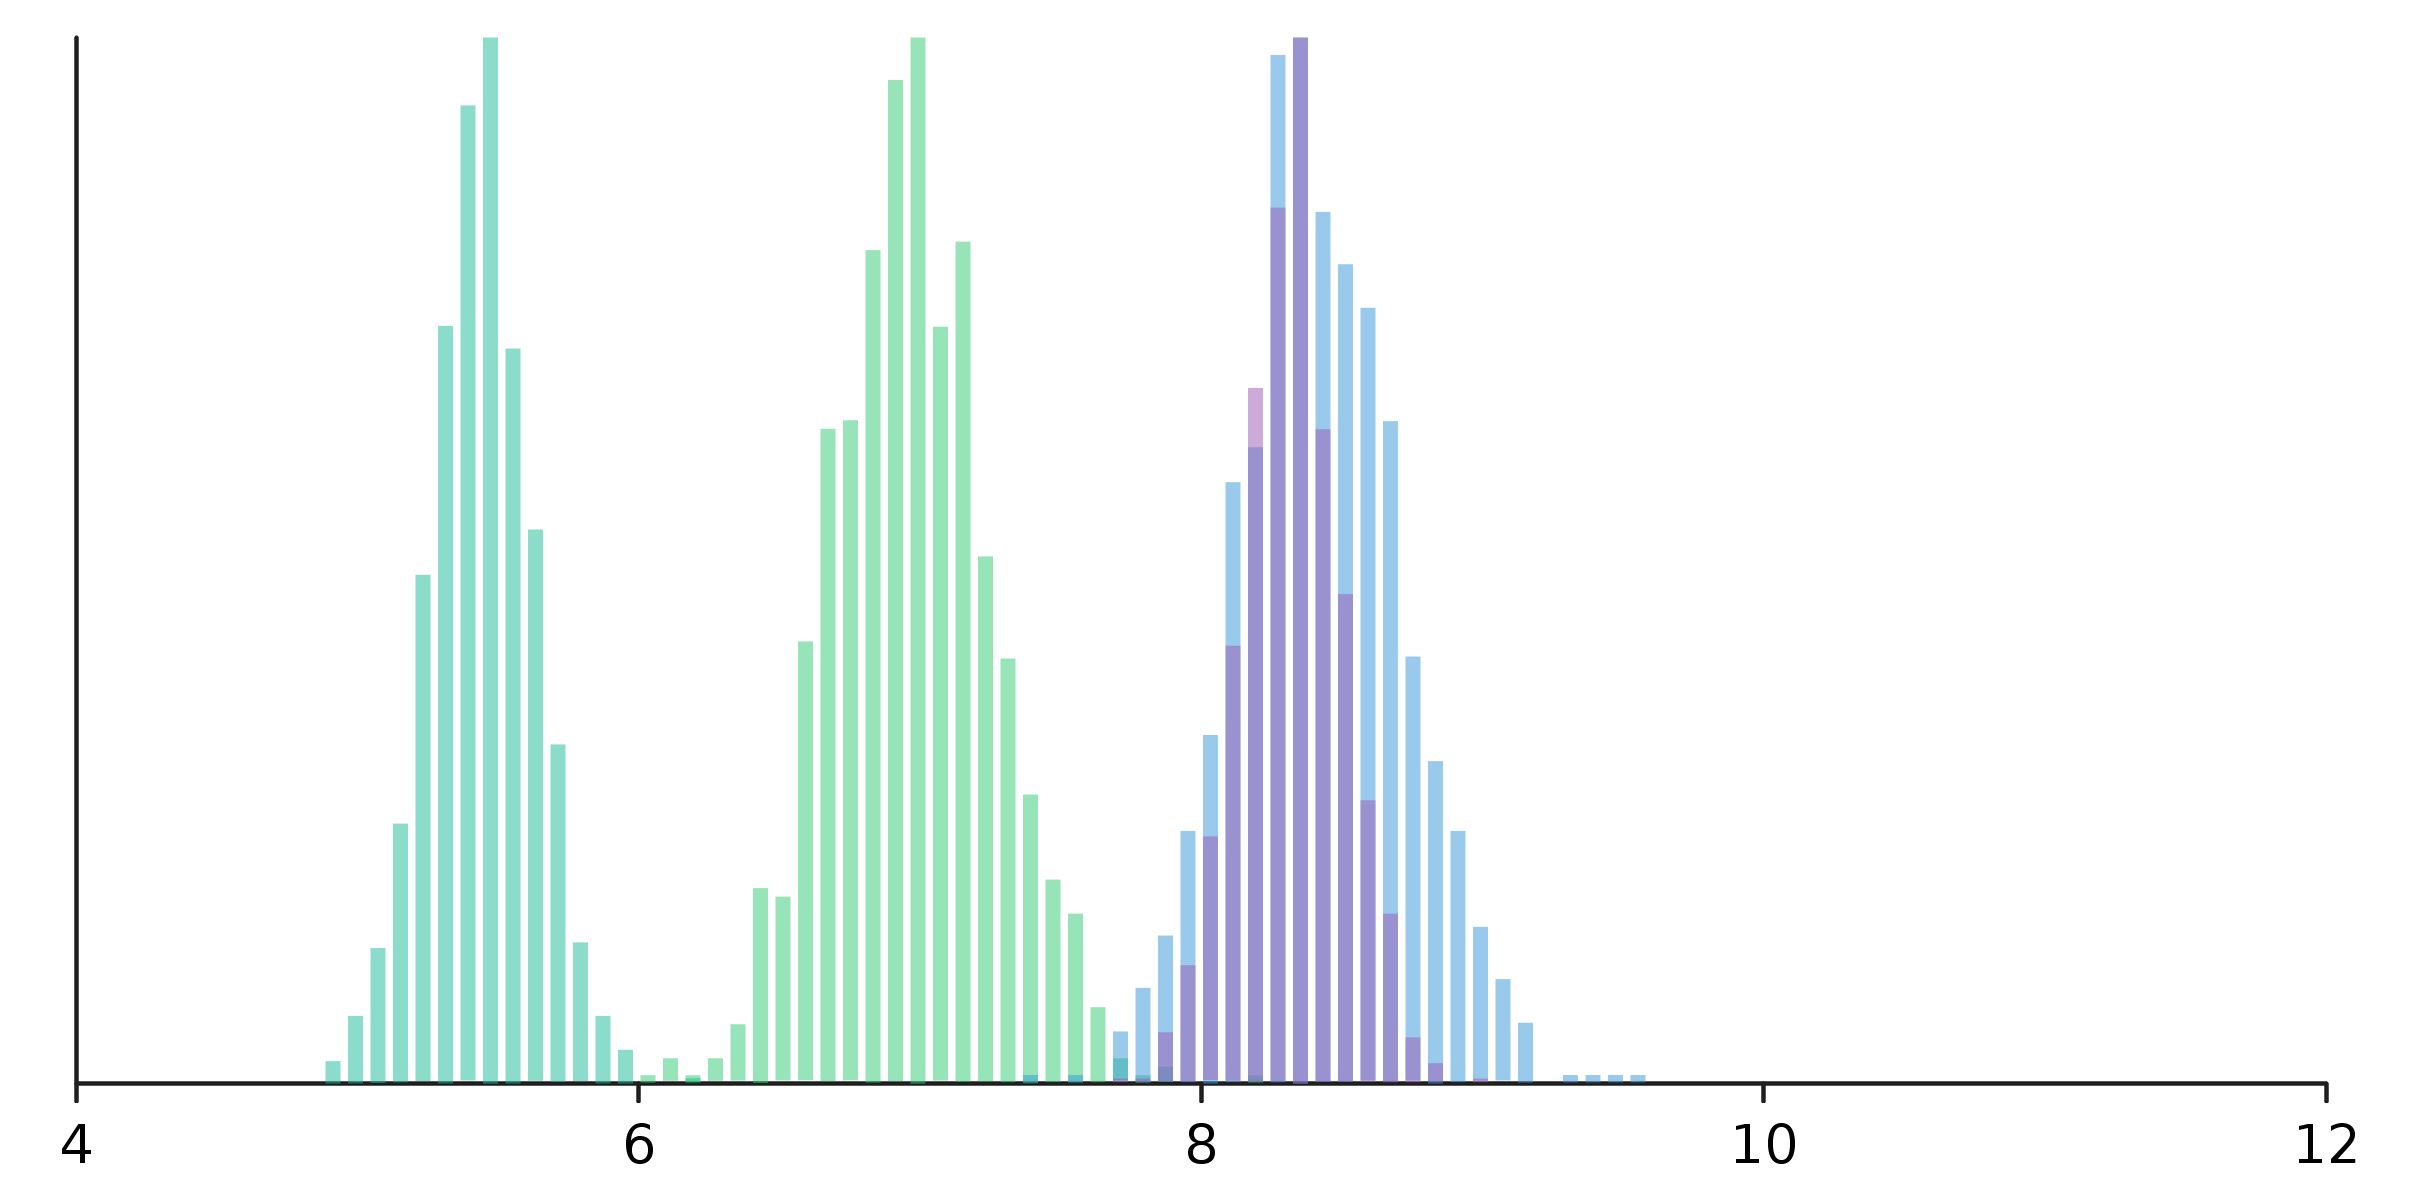

In [25]:
{{
    val plots = for { di <- 0 until n_diets } yield {
        val points = mus.drop(1000).map { s =>
            s._2(di)
        }

        Histogram(points,
                  bins = 100,
                  barRenderer = Some(BarRenderer.default(color = Some(colors(di)))))
    }
    Overlay(plots: _*)
        .xAxis()
        .frame()
        .render(Extent(600, 300))
        .show
}}

## Samples of variance the weight growth

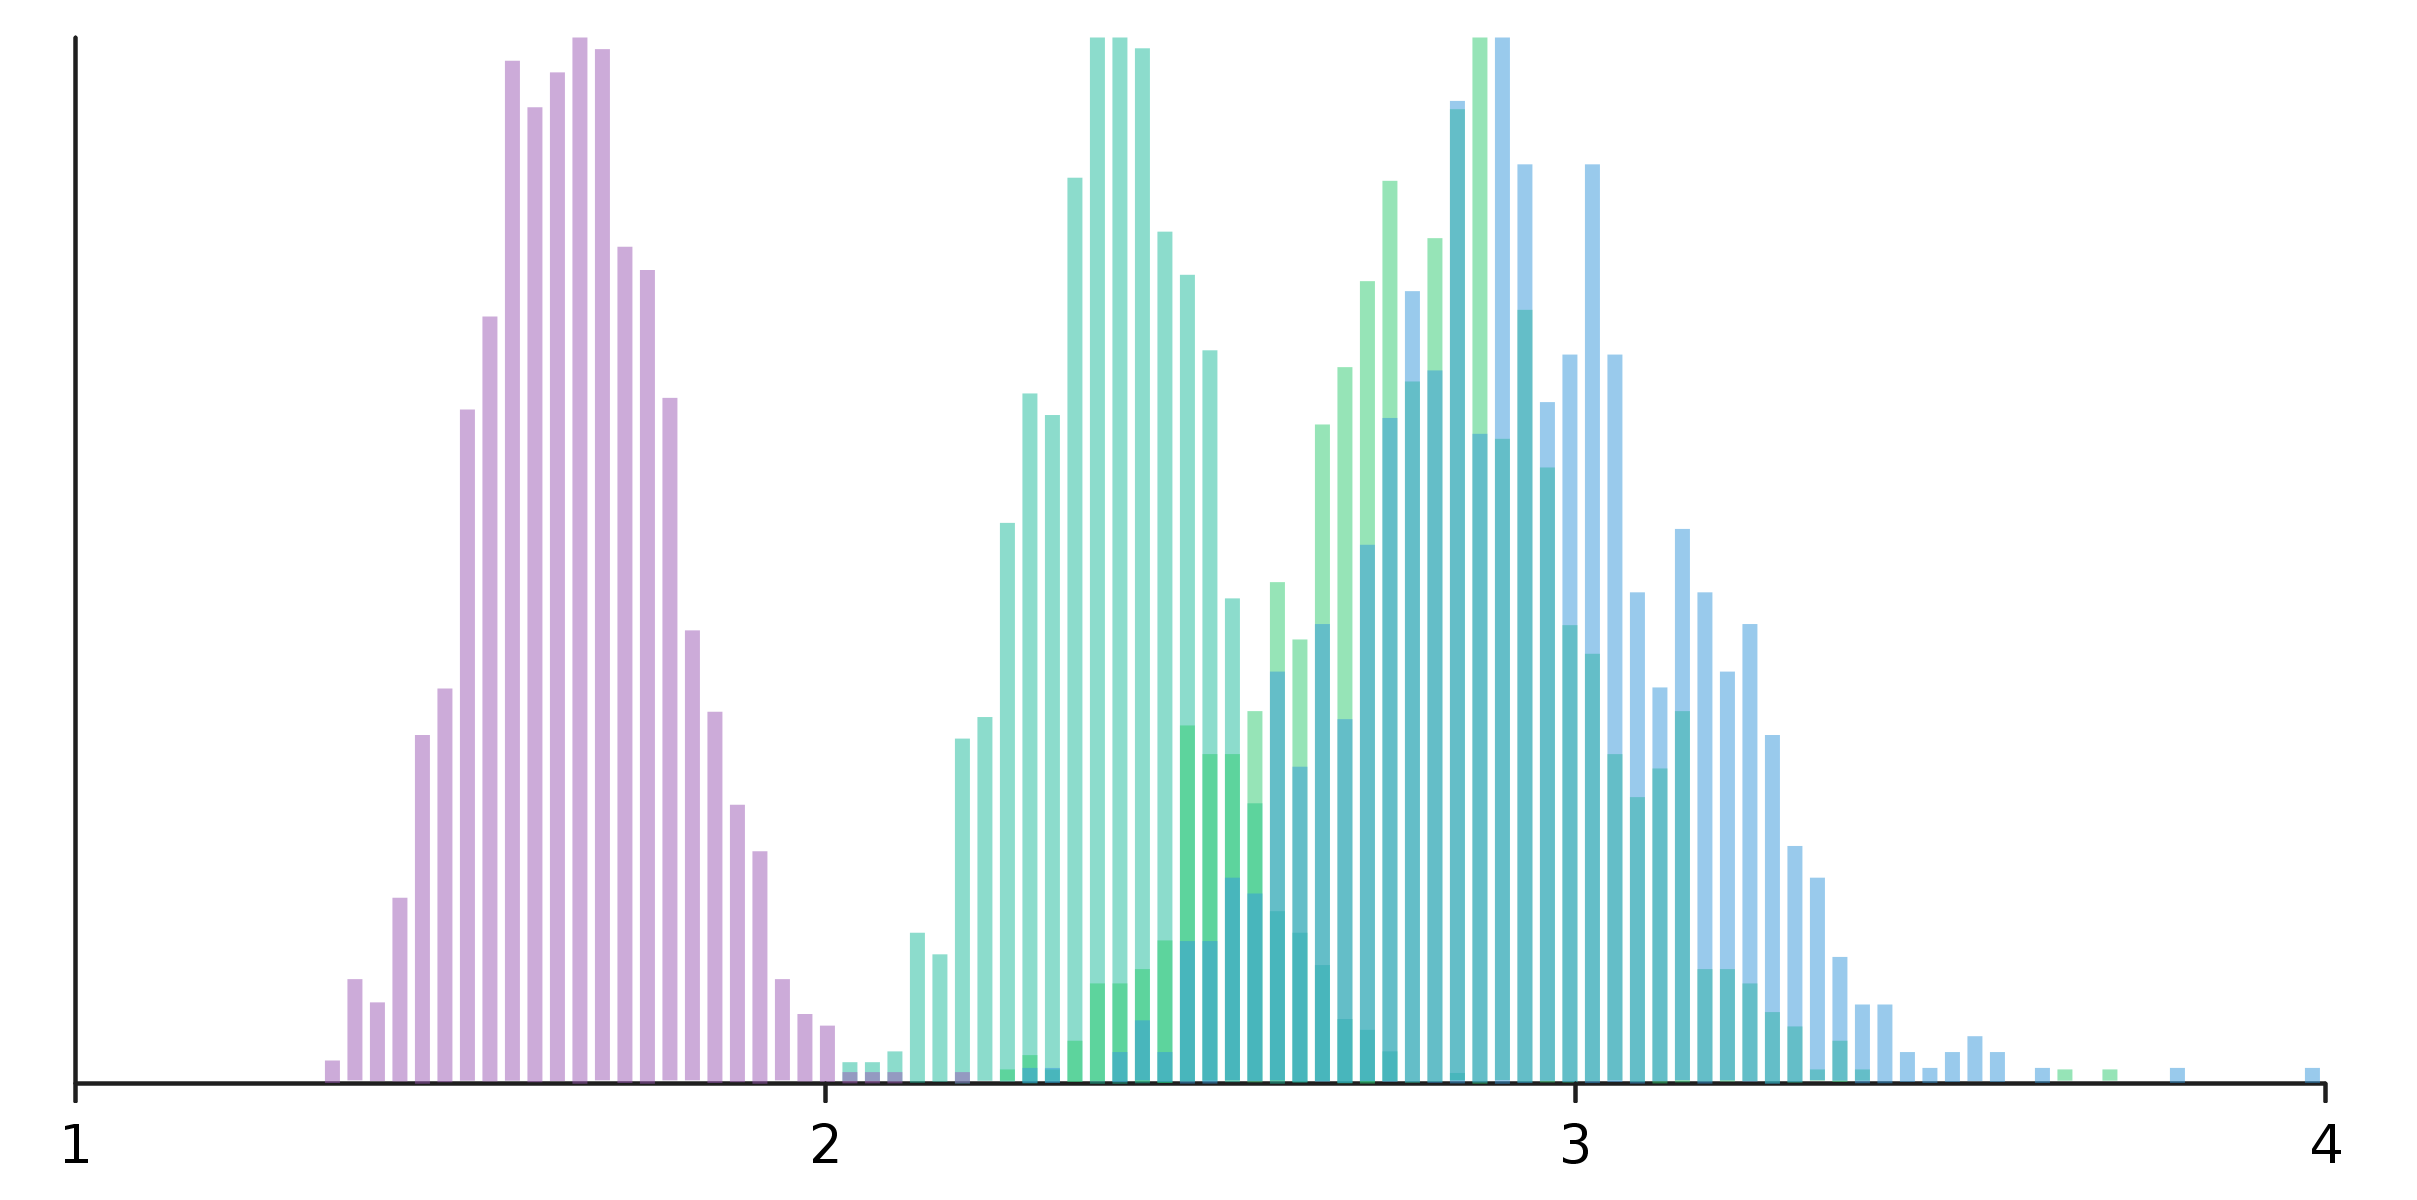

In [26]:
{{
    val plots = for { di <- 0 until n_diets } yield {
        val points = sigmas.drop(1000).map { s =>
            s._2(di)
        }

        Histogram(points,
                  bins = 100,
                  barRenderer = Some(BarRenderer.default(color = Some(colors(di)))))
    }
    Overlay(plots: _*)
        .xAxis()
        .frame()
        .render(Extent(600, 300))
        .show
}}